In [10]:
# Importación de librerías necesarias
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os
import sys
import pickle

# Configuración de logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [11]:
def load_json_data(filepath):
    """Carga el archivo JSON y retorna los datos."""
    logging.info("Cargando datos del archivo JSON: %s", filepath)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        logging.info("Carga de datos completada.")
        return data
    except Exception as e:
        logging.error("Error al cargar el archivo: %s", e)
        sys.exit(1)

def preprocess_rutas(data):
    """Extrae y preprocesa la sección 'rutas_historicas' del dataset."""
    logging.info("Extrayendo rutas históricas del dataset.")
    rutas = data.get('rutas_historicas', [])
    if not rutas:
        logging.warning("No se encontraron rutas en los datos.")
    
    lista_rutas = []
    for ruta in rutas:
        # Extraer métricas y valores de la ruta
        metricas = ruta.get('metricas', {})
        ruta_dict = {
            'fecha': ruta.get('fecha', None),
            'hora': ruta.get('hora', None),
            'origen': ruta.get('origen', None),
            'destino': ruta.get('destino', None),
            'tiempo_esperado': ruta.get('tiempo_esperado', np.nan),
            'tiempo_real': ruta.get('tiempo_real', np.nan),
            'costo': ruta.get('costo', np.nan),
            'distancia_km': ruta.get('distancia_km', np.nan),
            'ocupacion_porcentaje': metricas.get('ocupacion_porcentaje', np.nan),
            'satisfaccion_usuario': metricas.get('satisfaccion_usuario', np.nan),
            'retraso': metricas.get('retraso', np.nan)
        }
        lista_rutas.append(ruta_dict)
    
    df = pd.DataFrame(lista_rutas)
    logging.info("Se extrajeron %d registros de rutas.", len(df))
    return df

def clean_data(df):
    """Realiza la limpieza de datos eliminando registros con valores nulos."""
    initial_count = df.shape[0]
    df_clean = df.dropna().reset_index(drop=True)
    final_count = df_clean.shape[0]
    eliminados = initial_count - final_count
    logging.info("Limpieza de datos: se eliminaron %d registros con datos faltantes.", eliminados)
    return df_clean

# Definir la ruta del dataset
dataset_path = 'dataset_transporte_enriquecido.json'

# Cargar datos
data = load_json_data(dataset_path)
print('Carga de datos completa')

# Preprocesar rutas
df_rutas = preprocess_rutas(data)
print("Preview de los datos extraídos")
df_rutas.head()

# Limpieza de datos
df_rutas_limpio = clean_data(df_rutas)
print("Cantidad de registros eliminados durante la limpieza:", len(df_rutas) - len(df_rutas_limpio))

2025-04-13 14:47:38,249 - INFO - Cargando datos del archivo JSON: dataset_transporte_enriquecido.json
2025-04-13 14:47:38,265 - INFO - Carga de datos completada.
2025-04-13 14:47:38,267 - INFO - Extrayendo rutas históricas del dataset.
2025-04-13 14:47:38,280 - INFO - Se extrajeron 3600 registros de rutas.
2025-04-13 14:47:38,283 - INFO - Limpieza de datos: se eliminaron 0 registros con datos faltantes.


Carga de datos completa
Preview de los datos extraídos
Cantidad de registros eliminados durante la limpieza: 0


In [12]:
def convert_fecha_to_datetime(df, fecha_column='fecha'):
    """Convierte la columna de fechas a tipo datetime."""
    logging.info("Convirtiendo la columna '%s' a datetime.", fecha_column)
    df[fecha_column] = pd.to_datetime(df[fecha_column], format='%Y-%m-%d', errors='coerce')
    return df

def add_time_features(df):
    """Agrega características adicionales a partir de la columna 'fecha' y 'hora'."""
    logging.info("Agregando características temporales a los datos.")
    if 'fecha' in df.columns:
        df = convert_fecha_to_datetime(df, 'fecha')
        df['mes'] = df['fecha'].dt.month
        df['dia'] = df['fecha'].dt.day
    if 'hora' in df.columns:
        df['hora'] = pd.to_numeric(df['hora'], errors='coerce')
    return df

def select_features(df):
    """Selecciona las características numéricas relevantes para el clustering."""
    logging.info("Seleccionando características para el modelo.")
    features = [
        'tiempo_esperado',
        'tiempo_real',
        'costo',
        'distancia_km',
        'ocupacion_porcentaje',
        'satisfaccion_usuario',
        'retraso'
    ]
    if 'mes' in df.columns:
        features.append('mes')
    if 'hora' in df.columns:
        features.append('hora')

    df_features = df[features].copy()
    logging.info("Características seleccionadas: %s", features)
    return df_features, features

def scale_features(df):
    """Escala las características numéricas usando StandardScaler."""
    logging.info("Escalando las características numéricas.")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return X_scaled, scaler

# Agregar características temporales
df_rutas_feat = add_time_features(df_rutas_limpio)
print("Características temporales agregadas (columnas 'mes', 'dia' y 'hora'):")
df_rutas_feat[['fecha', 'hora', 'mes', 'dia']].head()

# Seleccionar características para el modelo
df_features, features_list = select_features(df_rutas_feat)
print("Características seleccionadas:", features_list)
df_features.head()

# Escalar características
X_scaled, scaler = scale_features(df_features)
print("Datos escalados. Primeras 5 filas:")
pd.DataFrame(X_scaled, columns=features_list).head()

2025-04-13 14:47:50,776 - INFO - Agregando características temporales a los datos.
2025-04-13 14:47:50,776 - INFO - Convirtiendo la columna 'fecha' a datetime.
2025-04-13 14:47:50,782 - INFO - Seleccionando características para el modelo.
2025-04-13 14:47:50,784 - INFO - Características seleccionadas: ['tiempo_esperado', 'tiempo_real', 'costo', 'distancia_km', 'ocupacion_porcentaje', 'satisfaccion_usuario', 'retraso', 'mes', 'hora']
2025-04-13 14:47:50,785 - INFO - Escalando las características numéricas.


Características temporales agregadas (columnas 'mes', 'dia' y 'hora'):
Características seleccionadas: ['tiempo_esperado', 'tiempo_real', 'costo', 'distancia_km', 'ocupacion_porcentaje', 'satisfaccion_usuario', 'retraso', 'mes', 'hora']
Datos escalados. Primeras 5 filas:


,tiempo_esperado,tiempo_real,costo,distancia_km,ocupacion_porcentaje,satisfaccion_usuario,retraso,mes,hora
0,-1.248757,-1.007537,-0.750,-1.513150,-1.244225,-0.406958,-0.597148,0.0,-1.661325
1,-0.427207,-0.455763,-0.125,-0.414214,-0.832529,0.709907,-0.365667,0.0,-1.661325
2,0.394344,-0.031141,-1.375,0.726988,-0.192112,-0.127741,-0.318915,0.0,-1.661325
3,-0.427207,-0.344310,1.125,-0.202881,-0.741041,0.570299,-0.203744,0.0,-1.661325
4,1.708826,1.295314,1.125,1.403257,-0.237856,1.407948,0.695953,0.0,-1.661325


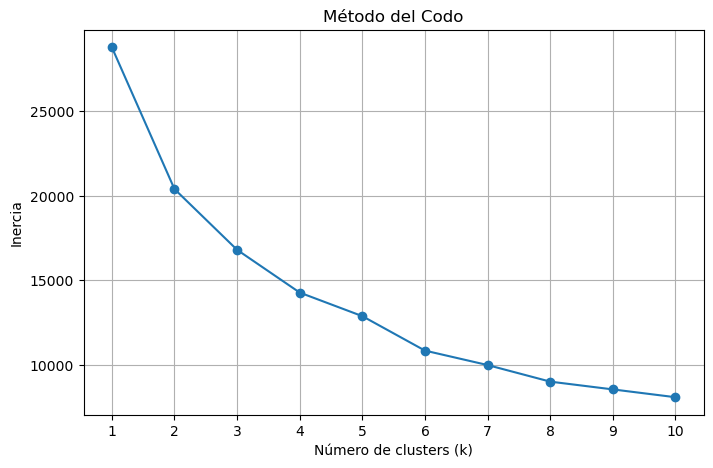

2025-04-13 14:48:01,704 - INFO - Gráfica del método del codo generada.
2025-04-13 14:48:01,705 - INFO - Aplicando K-Means con 5 clusters.
2025-04-13 14:48:01,742 - INFO - Clustering completado.
2025-04-13 14:48:01,743 - INFO - Evaluando la calidad del clustering.
2025-04-13 14:48:02,036 - INFO - La puntuación silhouette es: 0.2975


Silhouette Score: 0.2975
Distribución de clusters:
cluster
0    1655
4     578
2     568
3     545
1     254
Name: count, dtype: int64


In [13]:
def compute_kmeans(X, num_clusters=3, random_state=42):
    """Aplica K-Means al conjunto de datos."""
    logging.info("Aplicando K-Means con %d clusters.", num_clusters)
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(X)
    logging.info("Clustering completado.")
    return clusters, kmeans

def evaluate_clustering(X, labels):
    """Evalúa la calidad del clustering usando la puntuación silhouette."""
    logging.info("Evaluando la calidad del clustering.")
    try:
        score = silhouette_score(X, labels)
        logging.info("La puntuación silhouette es: %.4f", score)
        return score
    except Exception as e:
        logging.error("Error al calcular el silhouette score: %s", e)
        return None

def plot_elbow_method(X, max_k=10):
    """Calcula y muestra la gráfica del método del codo para determinar el número óptimo de clusters."""
    inertia = []
    k_range = range(1, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel("Número de clusters (k)")
    plt.ylabel("Inercia")
    plt.title("Método del Codo")
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    logging.info("Gráfica del método del codo generada.")

# Método del codo para determinar el número óptimo de clusters
plot_elbow_method(X_scaled, max_k=10)

# Aplicar K-Means con el número de clusters elegido
num_clusters = 5  # Ajustar según el resultado del método del codo
clusters, kmeans_model = compute_kmeans(X_scaled, num_clusters=num_clusters)

# Evaluar el clustering
silhouette = evaluate_clustering(X_scaled, clusters)
print(f"Silhouette Score: {silhouette:.4f}")

# Añadir las etiquetas de cluster al DataFrame original
df_rutas_feat['cluster'] = clusters
print("Distribución de clusters:")
print(df_rutas_feat['cluster'].value_counts())

2025-04-13 14:56:06,871 - INFO - Aplicando PCA para reducción de dimensionalidad.
2025-04-13 14:56:06,873 - INFO - PCA completado. Varianza explicada por componente: [0.43270393 0.22105893]
2025-04-13 14:56:06,874 - INFO - Generando gráfica de clusters.


Varianza explicada por los componentes principales: [0.43270393 0.22105893]


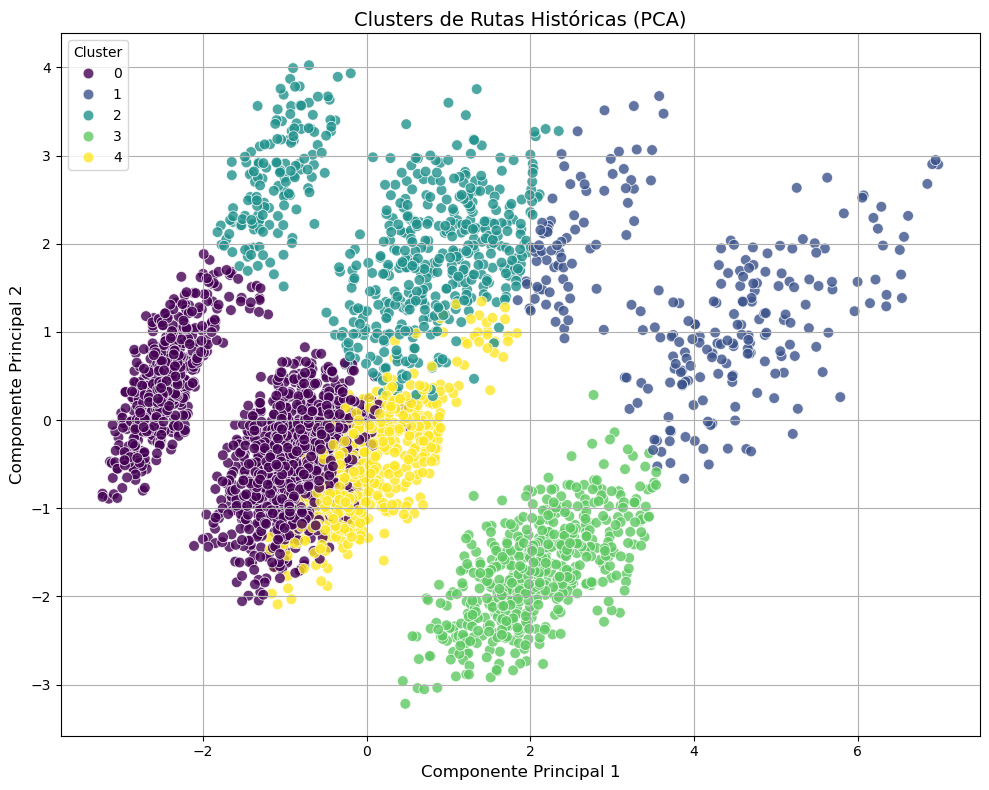

2025-04-13 14:56:07,188 - INFO - Generando gráficas de distribuciones por cluster.
2025-04-13 14:56:07,513 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 14:56:07,520 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 14:56:07,579 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 14:56:07,585 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-13 14:56:07,642 -

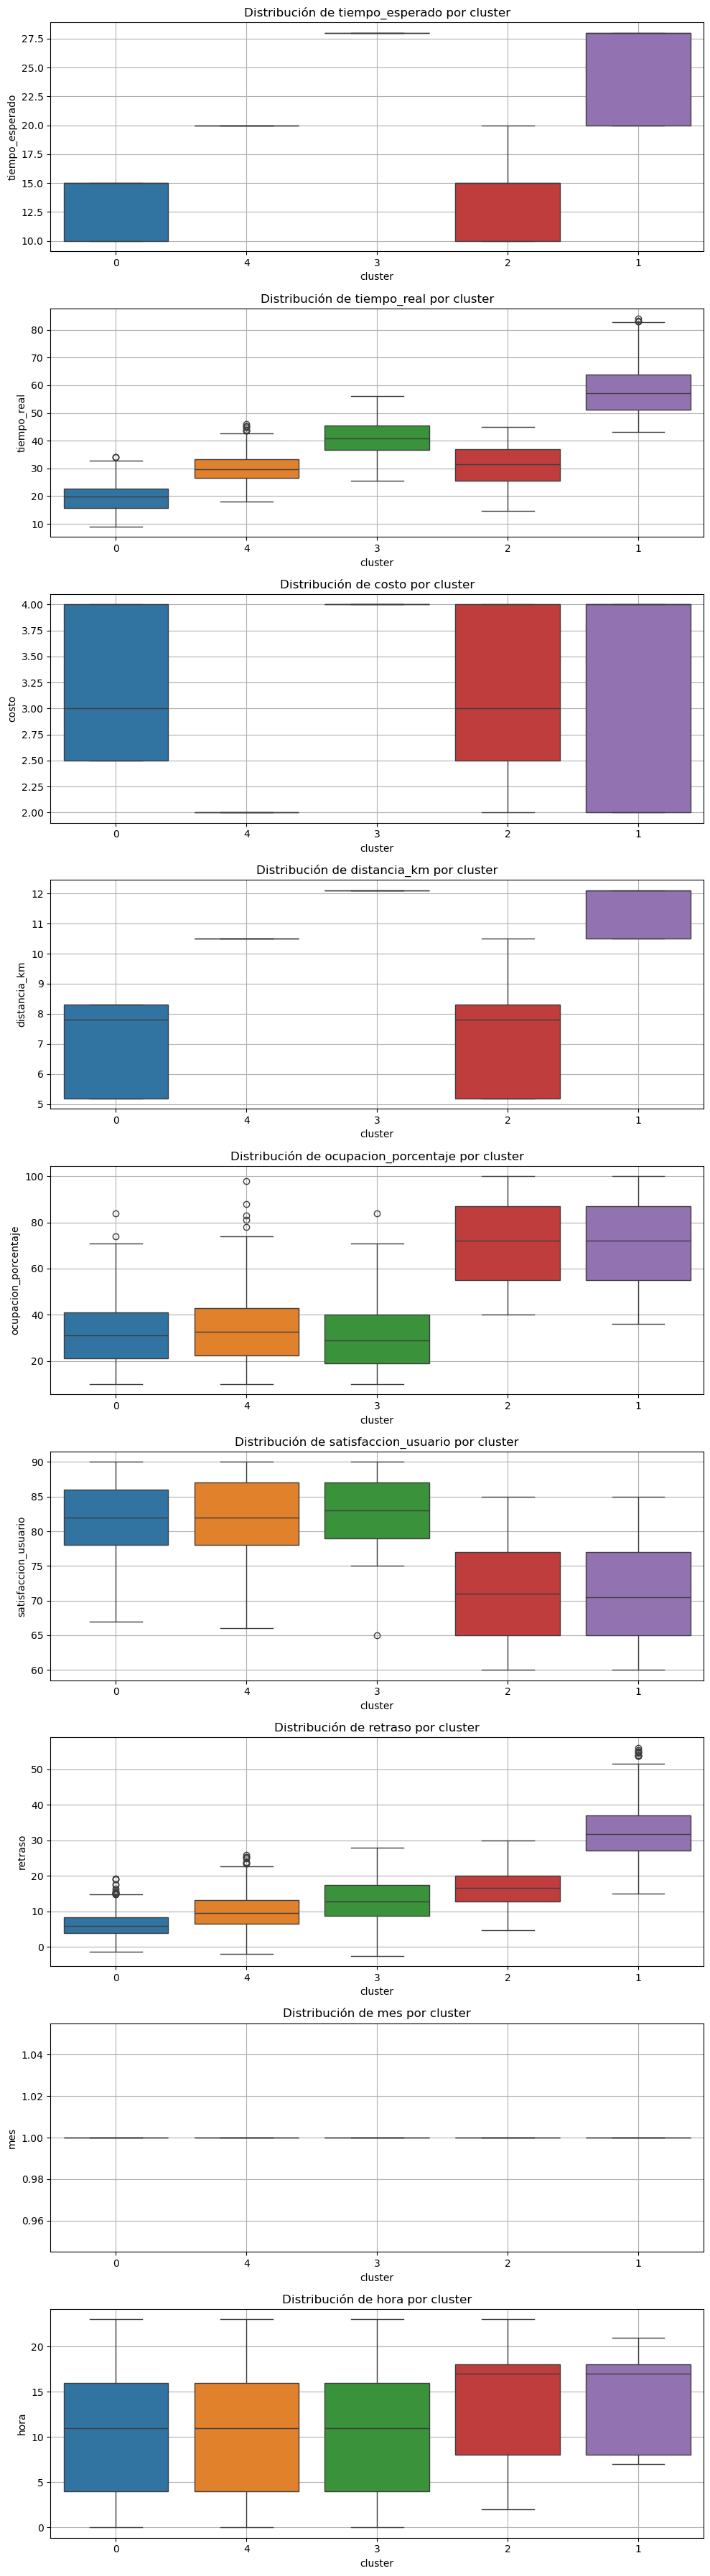

In [21]:
def reduce_dimensionality(X, n_components=2):
    """Reduce la dimensionalidad de los datos con PCA para visualización."""
    logging.info("Aplicando PCA para reducción de dimensionalidad.")
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    logging.info("PCA completado. Varianza explicada por componente: %s", pca.explained_variance_ratio_)
    return X_pca, pca

def plot_clusters(X_pca, labels, title='Clusters de Rutas Históricas'):
    """Grafica los clusters obtenidos en un plano 2D."""
    logging.info("Generando gráfica de clusters.")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=60, alpha=0.8)
    plt.title(title, fontsize=14)
    plt.xlabel('Componente Principal 1', fontsize=12)
    plt.ylabel('Componente Principal 2', fontsize=12)
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(df, cluster_labels):
    """Grafica las distribuciones de las características principales para cada cluster."""
    logging.info("Generando gráficas de distribuciones por cluster.")
    
    # Crear una copia del dataframe y asegurar que cluster sea numérico
    df_viz = df.copy()
    df_viz['cluster'] = cluster_labels
    df_viz['cluster'] = df_viz['cluster'].astype(str)  # Convertir a string para evitar advertencia
    
    # Seleccionar solo columnas numéricas
    numeric_features = df_viz.select_dtypes(include=['number']).columns.drop('cluster', errors='ignore')
    num_features = len(numeric_features)
    
    if num_features == 0:
        logging.warning("No se encontraron características numéricas para visualizar")
        return
        
    # Crear figura con subplots
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 4 * num_features))
    if num_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(numeric_features):
        # Usar hue en lugar de palette para evitar FutureWarning
        sns.boxplot(x='cluster', y=feature, data=df_viz, ax=axes[i], hue='cluster', legend=False)
        axes[i].set_title(f'Distribución de {feature} por cluster')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Reducir dimensionalidad con PCA para visualización
X_pca, pca = reduce_dimensionality(X_scaled)
print("Varianza explicada por los componentes principales:", pca.explained_variance_ratio_)

# Visualizar clusters en 2D
plot_clusters(X_pca, clusters, title='Clusters de Rutas Históricas (PCA)')

# Visualizar distribución de características por cluster
plot_feature_distributions(df_features, clusters)

2025-04-13 14:48:36,399 - INFO - Iniciando análisis exploratorio adicional.


Estadísticos descriptivos por cluster:
        tiempo_esperado                                                     \
                  count       mean       std   min   25%   50%   75%   max   
cluster                                                                      
0                1655.0  13.277946  2.376597  10.0  10.0  15.0  15.0  15.0   
1                 254.0  25.511811  3.710611  20.0  20.0  28.0  28.0  28.0   
2                 568.0  14.234155  2.967150  10.0  10.0  15.0  15.0  20.0   
3                 545.0  28.000000  0.000000  28.0  28.0  28.0  28.0  28.0   
4                 578.0  20.000000  0.000000  20.0  20.0  20.0  20.0  20.0   

        tiempo_real             ...  mes         hora                       \
              count       mean  ...  75%  max   count       mean       std   
cluster                         ...                                          
0            1655.0  19.621178  ...  1.0  1.0  1655.0  10.984290  7.311335   
1             254.0  58.

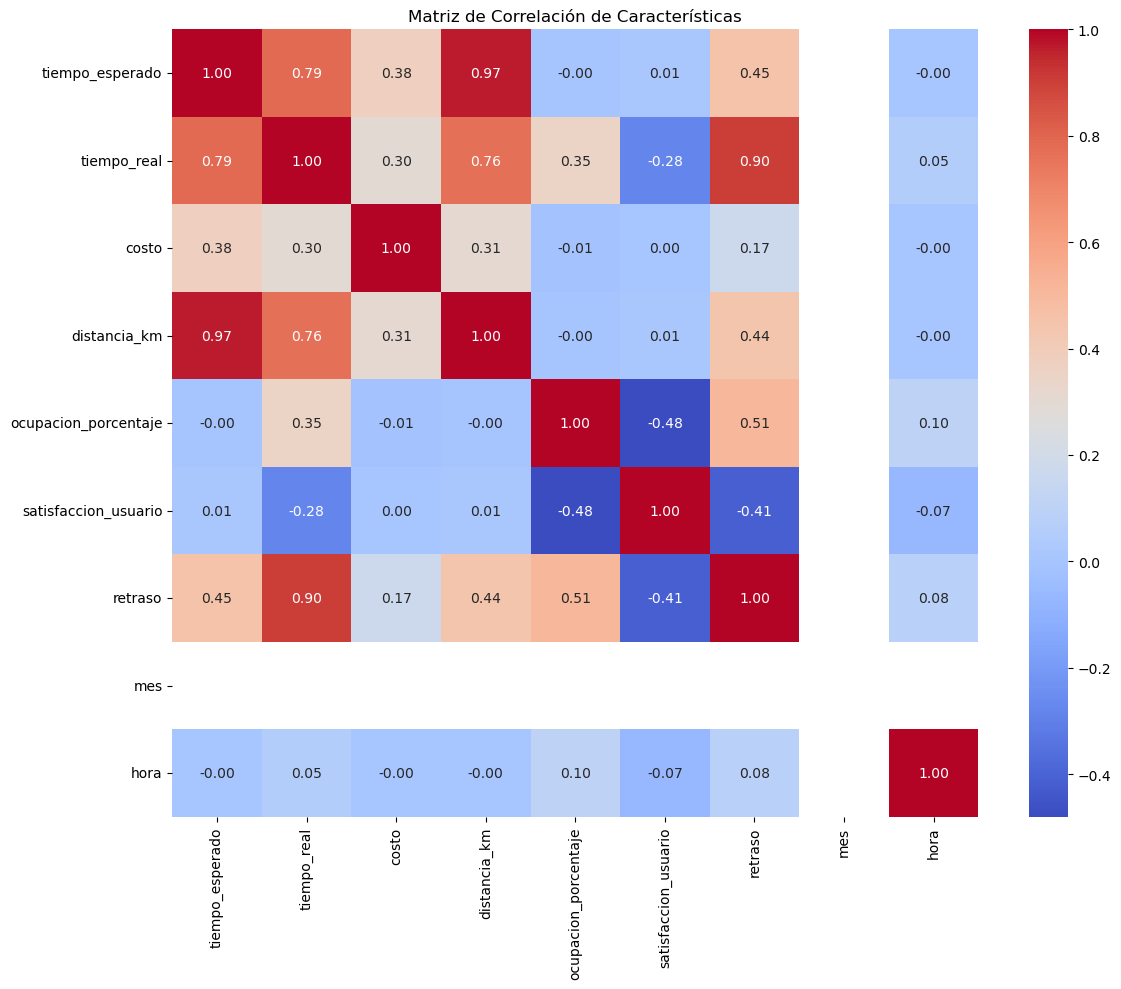

In [15]:
def additional_analysis(df):
    """Realiza un análisis exploratorio adicional con estadísticos descriptivos y correlaciones."""
    logging.info("Iniciando análisis exploratorio adicional.")
    
    # Estadísticos descriptivos
    print("Estadísticos descriptivos por cluster:")
    print(df.groupby('cluster').describe())
    
    # Gráfica de correlaciones
    plt.figure(figsize=(12, 10))
    corr_matrix = df.drop('cluster', axis=1).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matriz de Correlación de Características")
    plt.tight_layout()
    plt.show()

# Preparar datos para análisis adicional
df_analisis = df_features.copy()
df_analisis['cluster'] = clusters

# Realizar análisis adicional
additional_analysis(df_analisis)

In [16]:
def save_model(kmeans_model, scaler, pca_model, output_dir="modelos"):
    """Guarda los modelos entrenados en archivos pickle para usos futuros."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    model_files = {
        'kmeans_model.pkl': kmeans_model,
        'scaler.pkl': scaler,
        'pca_model.pkl': pca_model
    }
    
    for filename, model in model_files.items():
        filepath = os.path.join(output_dir, filename)
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        logging.info("Modelo guardado en: %s", filepath)

# Guardar resultados en CSV
output_csv = "rutas_clusterizadas.csv"
df_rutas_feat.to_csv(output_csv, index=False, encoding='utf-8')
print(f"Resultados guardados en {output_csv}")

# Guardar modelos
save_model(kmeans_model, scaler, pca)
print("Modelos guardados en el directorio 'modelos'")

2025-04-13 14:48:58,031 - INFO - Modelo guardado en: modelos/kmeans_model.pkl
2025-04-13 14:48:58,032 - INFO - Modelo guardado en: modelos/scaler.pkl
2025-04-13 14:48:58,033 - INFO - Modelo guardado en: modelos/pca_model.pkl


Resultados guardados en rutas_clusterizadas.csv
Modelos guardados en el directorio 'modelos'


Perfiles de clusters:
              hora  tiempo_esperado  tiempo_real     costo  distancia_km  \
cluster                                                                    
0        10.984290        13.277946    19.621178  3.155287      7.068278   
1        13.169291        25.511811    58.665079  3.377953     11.602362   
2        13.188380        14.234155    31.074877  3.070423      7.569542   
3        10.970642        28.000000    41.122440  4.000000     12.100000   
4        11.083045        20.000000    30.076280  2.000000     10.500000   

         ocupacion_porcentaje  satisfaccion_usuario    retraso  mes  \
cluster                                                               
0                   30.832628             82.445317   6.343233  1.0   
1                   71.094488             71.417323  33.153268  1.0   
2                   71.024648             71.241197  16.840722  1.0   
3                   29.763303             82.660550  13.122440  1.0   
4                  

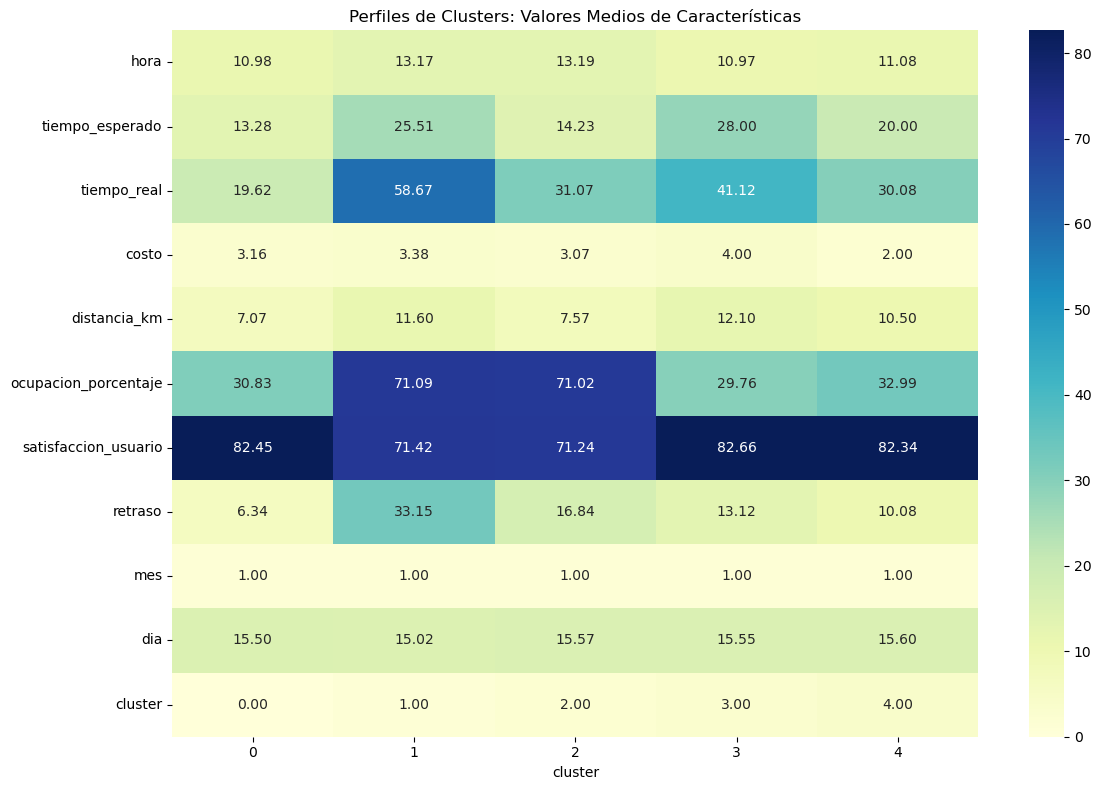

In [19]:
# Analizar características de cada cluster, solo para columnas numéricas
numeric_cols = df_rutas_feat.select_dtypes(include=['number']).columns
cluster_profiles = df_rutas_feat.groupby('cluster')[numeric_cols].mean()
print("Perfiles de clusters:")
print(cluster_profiles)

# Visualizar perfiles de cluster
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Perfiles de Clusters: Valores Medios de Características')
plt.tight_layout()
plt.show()